In [1]:
# Statistical Analysis Notebook for Nuclear Energy Projection
#
# This script performs rigorous statistical analysis on the nuclear power tracker data
# and projection results. Convert to Jupyter notebook with:
#   jupytext --to ipynb 02_statistical_analysis.py
#
# Or run directly as a Python script

# Nuclear Energy Projection - Statistical Analysis

This notebook performs comprehensive statistical analysis including:
- Descriptive statistics and distributions
- Hypothesis testing
- Correlation analysis
- Time series analysis
- Regression modeling
- Uncertainty quantification

**Author**: Research Team
**Date**: 2026-01-03

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, kstest, ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Load Data

In [3]:
# Load processed datasets
tracker = pd.read_csv('../data/processed/nuclear_tracker_cleaned.csv')
features = pd.read_csv('../data/processed/nuclear_features.csv')
projections = pd.read_csv('../data/processed/nuclear_projections_2050.csv')
scenario_comp = pd.read_csv('../data/processed/scenario_comparison.csv')
emissions = pd.read_csv('../data/processed/avoided_emissions.csv')

print("Data loaded successfully!")
print(f"Nuclear Tracker: {tracker.shape}")
print(f"Features: {features.shape}")
print(f"Projections: {projections.shape}")
print(f"Scenario Comparison: {scenario_comp.shape}")
print(f"Emissions: {emissions.shape}")

Data loaded successfully!
Nuclear Tracker: (1749, 39)
Features: (1749, 18)
Projections: (104, 5)
Scenario Comparison: (142, 10)
Emissions: (104, 7)


## 2. Descriptive Statistics & Distributions

Analyze the statistical properties of plant capacities, regional distributions,
and projection uncertainties.

In [4]:
print("="*80)
print("DESCRIPTIVE STATISTICS - PLANT CAPACITY")
print("="*80)

# Capacity statistics by status
capacity_stats = tracker.groupby('Status')['capacity_numeric'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(2)

print("\nCapacity Statistics by Plant Status:")
print(capacity_stats)

DESCRIPTIVE STATISTICS - PLANT CAPACITY

Capacity Statistics by Plant Status:
                          count     mean  median     std    min     max  \
Status                                                                    
announced                   290   603.45   300.0  518.30    5.0  1650.0   
cancelled                   312  1050.20  1117.0  359.06    1.5  1830.0   
cancelled - inferred 4 y    232  1026.54  1250.0  380.33   15.0  1750.0   
construction                 76  1073.22  1200.0  398.25    1.0  1720.0   
mothballed                   25   837.08  1100.0  424.94   29.0  1385.0   
operating                   421   953.30  1000.0  327.73    5.0  1750.0   
pre-construction            140   764.94  1000.0  565.19    5.0  1730.0   
retired                     227   510.55   440.0  422.40    0.2  1485.0   
shelved                      15  1252.47  1373.0  373.27    5.0  1590.0   
shelved - inferred 2 y       11   884.09  1200.0  536.41  345.0  1600.0   

                     

In [5]:
# Test for normality of capacity distribution
print("\n" + "="*80)
print("NORMALITY TESTS - Capacity Distribution")
print("="*80)

capacity_clean = tracker['capacity_numeric'].dropna()

# Shapiro-Wilk test (if n < 5000)
if len(capacity_clean) < 5000:
    stat, p_value = stats.shapiro(capacity_clean)
    print(f"\nShapiro-Wilk Test:")
    print(f"  Statistic: {stat:.6f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Result: {'Normal' if p_value > 0.05 else 'Not Normal'} distribution (α=0.05)")

# Kolmogorov-Smirnov test
stat, p_value = kstest(capacity_clean, 'norm', args=(capacity_clean.mean(), capacity_clean.std()))
print(f"\nKolmogorov-Smirnov Test:")
print(f"  Statistic: {stat:.6f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Result: {'Normal' if p_value > 0.05 else 'Not Normal'} distribution (α=0.05)")


NORMALITY TESTS - Capacity Distribution

Shapiro-Wilk Test:
  Statistic: 0.911002
  P-value: 0.000000
  Result: Not Normal distribution (α=0.05)

Kolmogorov-Smirnov Test:
  Statistic: 0.171057
  P-value: 0.000000
  Result: Not Normal distribution (α=0.05)



[SAVED] Capacity distribution plots


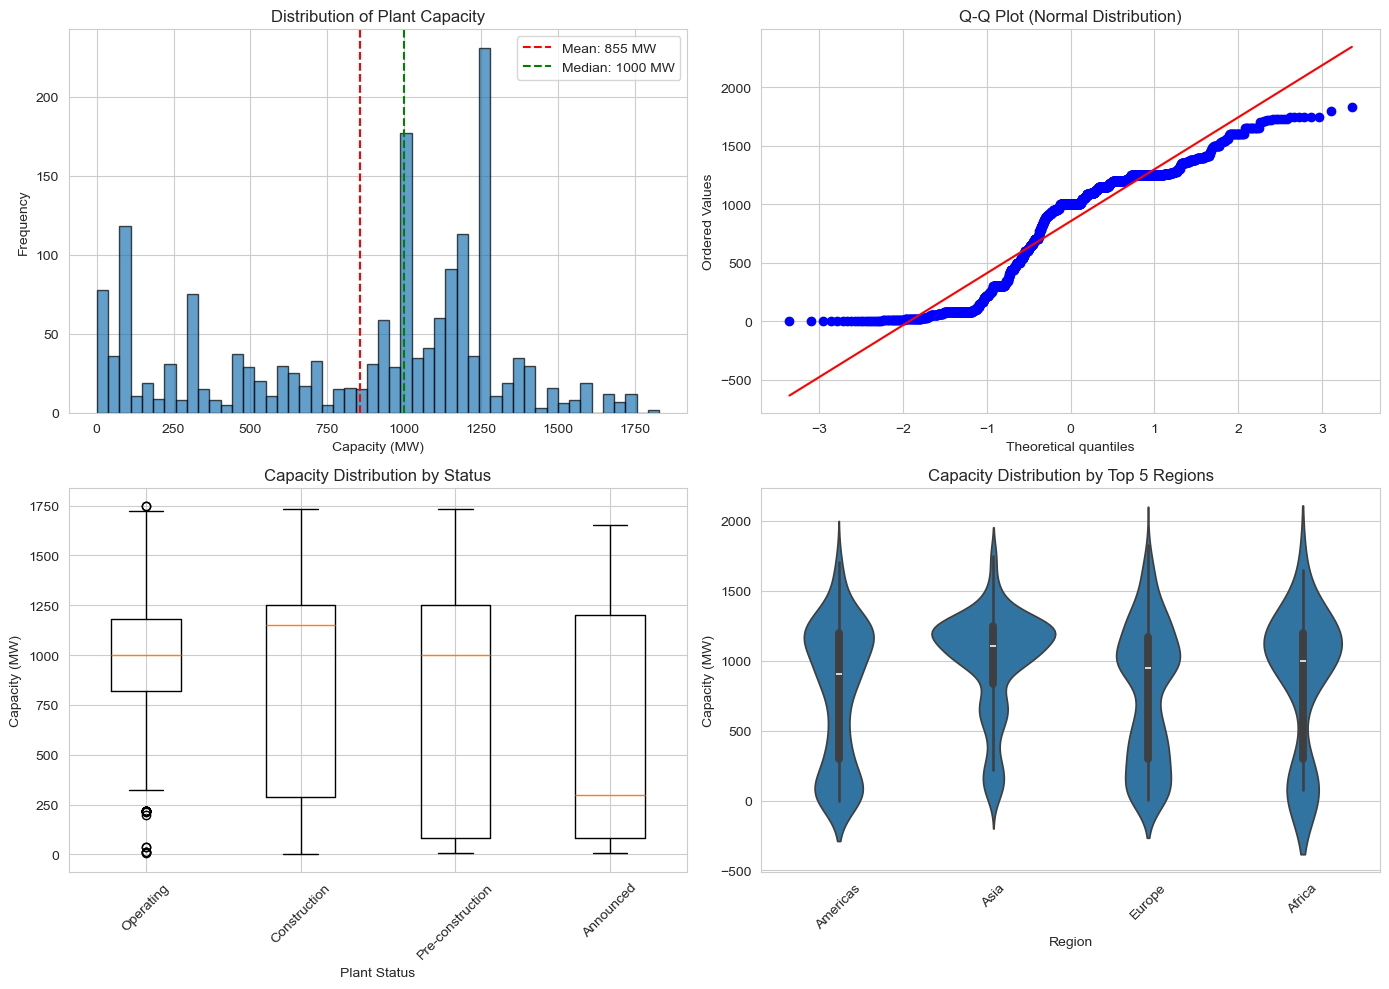

In [6]:
# Visualize capacity distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(capacity_clean, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Capacity (MW)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Plant Capacity')
axes[0, 0].axvline(capacity_clean.mean(), color='red', linestyle='--', label=f'Mean: {capacity_clean.mean():.0f} MW')
axes[0, 0].axvline(capacity_clean.median(), color='green', linestyle='--', label=f'Median: {capacity_clean.median():.0f} MW')
axes[0, 0].legend()

# Q-Q plot
stats.probplot(capacity_clean, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Normal Distribution)')

# Box plot by status
status_order = ['operating', 'construction', 'pre-construction', 'announced']
status_data = [tracker[tracker['Status'].str.lower().str.contains(s, na=False)]['capacity_numeric'].dropna()
               for s in status_order]
axes[1, 0].boxplot(status_data, labels=[s.capitalize() for s in status_order])
axes[1, 0].set_xlabel('Plant Status')
axes[1, 0].set_ylabel('Capacity (MW)')
axes[1, 0].set_title('Capacity Distribution by Status')
axes[1, 0].tick_params(axis='x', rotation=45)

# Violin plot by region
top_regions = tracker['Region'].value_counts().head(5).index
region_data = tracker[tracker['Region'].isin(top_regions)]
sns.violinplot(data=region_data, x='Region', y='capacity_numeric', ax=axes[1, 1])
axes[1, 1].set_xlabel('Region')
axes[1, 1].set_ylabel('Capacity (MW)')
axes[1, 1].set_title('Capacity Distribution by Top 5 Regions')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/capacity_distributions.png', dpi=150, bbox_inches='tight')
print("\n[SAVED] Capacity distribution plots")

## 3. Hypothesis Testing

Test statistical hypotheses about differences between groups.

In [7]:
print("\n" + "="*80)
print("HYPOTHESIS TESTING")
print("="*80)

# Test 1: Are pipeline plants significantly different from operating plants?
print("\n[TEST 1] Capacity: Operating vs Pipeline Plants")

operating_capacity = tracker[tracker['Status'].str.lower() == 'operating']['capacity_numeric'].dropna()
pipeline_mask = tracker['Status'].str.lower().str.contains('construction|announced|planned', na=False)
pipeline_capacity = tracker[pipeline_mask]['capacity_numeric'].dropna()

# Independent t-test
t_stat, p_value_t = ttest_ind(operating_capacity, pipeline_capacity)
print(f"\nIndependent T-Test:")
print(f"  Operating mean: {operating_capacity.mean():.2f} MW")
print(f"  Pipeline mean: {pipeline_capacity.mean():.2f} MW")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value_t:.4f}")
print(f"  Result: {'Significantly different' if p_value_t < 0.05 else 'No significant difference'} (α=0.05)")

# Mann-Whitney U test (non-parametric alternative)
u_stat, p_value_u = mannwhitneyu(operating_capacity, pipeline_capacity, alternative='two-sided')
print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  P-value: {p_value_u:.4f}")
print(f"  Result: {'Significantly different' if p_value_u < 0.05 else 'No significant difference'} (α=0.05)")


HYPOTHESIS TESTING

[TEST 1] Capacity: Operating vs Pipeline Plants

Independent T-Test:
  Operating mean: 953.30 MW
  Pipeline mean: 718.69 MW
  T-statistic: 7.7913
  P-value: 0.0000
  Result: Significantly different (α=0.05)

Mann-Whitney U Test:
  U-statistic: 125024.0000
  P-value: 0.0000
  Result: Significantly different (α=0.05)


In [8]:
# Test 2: Regional differences in deployment patterns
print("\n[TEST 2] Regional Differences in Nuclear Deployment")

# Chi-square test for status distribution across regions
top_5_regions = tracker['Region'].value_counts().head(5).index
region_status = tracker[tracker['Region'].isin(top_5_regions)]

# Create contingency table
contingency_table = pd.crosstab(region_status['Region'], region_status['Status'])
print("\nContingency Table (Region × Status):")
print(contingency_table)

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-Square Test of Independence:")
print(f"  Chi-square: {chi2:.4f}")
print(f"  Degrees of freedom: {dof}")
print(f"  P-value: {p_value:.6f}")
print(f"  Result: {'Regional patterns differ significantly' if p_value < 0.05 else 'No significant regional differences'} (α=0.05)")


[TEST 2] Regional Differences in Nuclear Deployment

Contingency Table (Region × Status):
Status    announced  cancelled  cancelled - inferred 4 y  construction  \
Region                                                                   
Africa           30          2                         0             4   
Americas         71        182                         5             4   
Asia             91         35                       201            58   
Europe           98         93                        26            10   

Status    mothballed  operating  pre-construction  retired  shelved  \
Region                                                                
Africa             0          2                 4        0        0   
Americas           3        120                36       53        2   
Asia              22        132                59       38        8   
Europe             0        167                41      136        5   

Status    shelved - inferred 2 y  
Re

In [9]:
# Test 3: ANOVA - Capacity differences across multiple regions
print("\n[TEST 3] ANOVA - Capacity Across Regions")

# Prepare data for ANOVA
region_groups = [tracker[tracker['Region'] == region]['capacity_numeric'].dropna()
                 for region in top_5_regions]

# One-way ANOVA
f_stat, p_value_anova = stats.f_oneway(*region_groups)
print(f"\nOne-Way ANOVA:")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  P-value: {p_value_anova:.6f}")
print(f"  Result: {'Significant differences between regions' if p_value_anova < 0.05 else 'No significant differences'} (α=0.05)")

# Post-hoc Tukey HSD test
if p_value_anova < 0.05:
    print("\n[POST-HOC] Tukey HSD Test (pairwise comparisons):")

    # Prepare data for Tukey
    region_capacity_df = tracker[tracker['Region'].isin(top_5_regions)][['Region', 'capacity_numeric']].dropna()

    tukey = pairwise_tukeyhsd(endog=region_capacity_df['capacity_numeric'],
                             groups=region_capacity_df['Region'],
                             alpha=0.05)
    print(tukey)


[TEST 3] ANOVA - Capacity Across Regions

One-Way ANOVA:
  F-statistic: 36.2018
  P-value: 0.000000
  Result: Significant differences between regions (α=0.05)

[POST-HOC] Tukey HSD Test (pairwise comparisons):
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1   group2   meandiff p-adj    lower     upper   reject
-------------------------------------------------------------
  Africa Americas  -98.6136 0.4892 -277.6517   80.4245  False
  Africa     Asia  132.3106 0.2192  -44.7388  309.3599  False
  Africa   Europe  -105.748 0.4196   -283.47    71.974  False
Americas     Asia  230.9241    0.0   161.012  300.8363   True
Americas   Europe   -7.1344 0.9941  -78.7328    64.464  False
    Asia   Europe -238.0586    0.0 -304.5278 -171.5894   True
-------------------------------------------------------------


## 4. Correlation Analysis

Analyze relationships between variables.

In [10]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Create numerical features for correlation
correlation_df = features[['capacity_numeric', 'capacity_factor', 'annual_generation_twh']].dropna()

# Add start year
correlation_df['start_year'] = pd.to_numeric(tracker['Start Year'], errors='coerce')

# Correlation matrix
corr_matrix = correlation_df.corr()
print("\nCorrelation Matrix:")
print(corr_matrix.round(3))


CORRELATION ANALYSIS

Correlation Matrix:
                       capacity_numeric  capacity_factor  \
capacity_numeric                  1.000            0.119   
capacity_factor                   0.119            1.000   
annual_generation_twh             0.999            0.168   
start_year                        0.136           -0.199   

                       annual_generation_twh  start_year  
capacity_numeric                       0.999       0.136  
capacity_factor                        0.168      -0.199  
annual_generation_twh                  1.000       0.121  
start_year                             0.121       1.000  



[SAVED] Correlation matrix heatmap


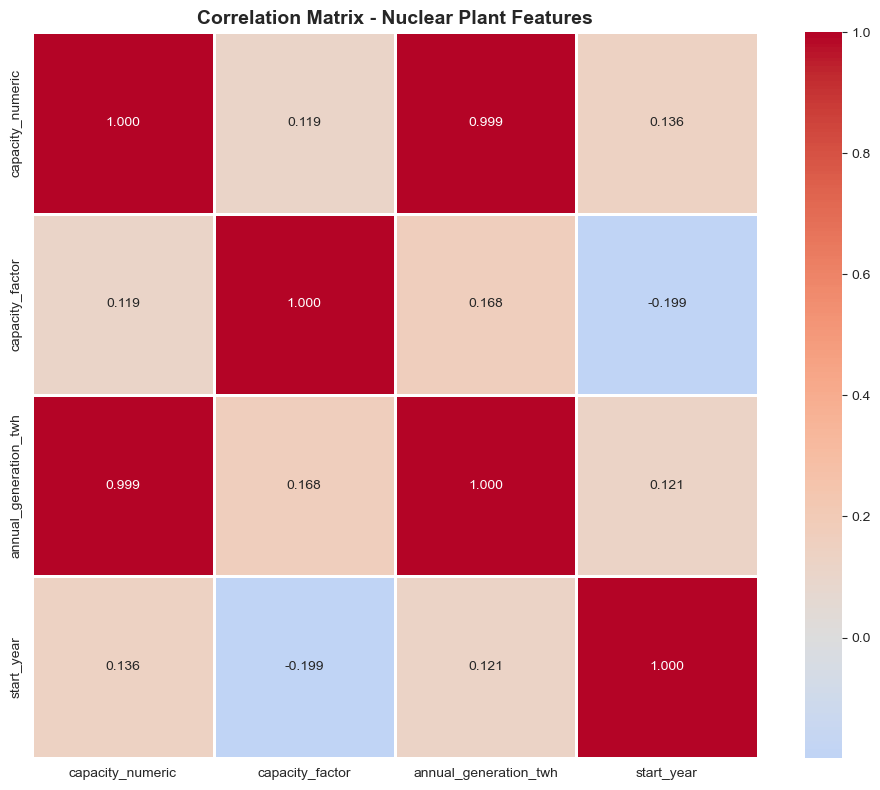

In [11]:
# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', square=True, linewidths=1)
plt.title('Correlation Matrix - Nuclear Plant Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/correlation_matrix.png', dpi=150, bbox_inches='tight')
print("\n[SAVED] Correlation matrix heatmap")

In [12]:
# Partial correlation analysis
print("\n[PARTIAL CORRELATION] Capacity vs Generation (controlling for Capacity Factor)")

# Calculate partial correlation manually
# Partial corr(X,Y|Z) = (corr(X,Y) - corr(X,Z)*corr(Y,Z)) / sqrt((1-corr(X,Z)^2)*(1-corr(Y,Z)^2))

X = correlation_df['capacity_numeric']
Y = correlation_df['annual_generation_twh']
Z = correlation_df['capacity_factor']

r_xy = X.corr(Y)
r_xz = X.corr(Z)
r_yz = Y.corr(Z)

partial_corr = (r_xy - r_xz * r_yz) / np.sqrt((1 - r_xz**2) * (1 - r_yz**2))

print(f"  Pearson correlation (Capacity × Generation): {r_xy:.4f}")
print(f"  Partial correlation (controlling for CF): {partial_corr:.4f}")
print(f"  Interpretation: Capacity factor {'partially' if abs(partial_corr) < abs(r_xy) else 'does not'} explain the relationship")


[PARTIAL CORRELATION] Capacity vs Generation (controlling for Capacity Factor)
  Pearson correlation (Capacity × Generation): 0.9986
  Partial correlation (controlling for CF): 0.9998
  Interpretation: Capacity factor does not explain the relationship


## 5. Time Series Analysis

Analyze temporal trends in nuclear deployment and projections.

In [13]:
print("\n" + "="*80)
print("TIME SERIES ANALYSIS")
print("="*80)

# Aggregate projections by year (global)
global_ts = projections.groupby('year').agg({
    'generation_twh': 'sum',
    'capacity_gw': 'sum'
}).reset_index()

print("\nGlobal Nuclear Generation Time Series (2025-2050):")
print(global_ts.head(10))


TIME SERIES ANALYSIS

Global Nuclear Generation Time Series (2025-2050):
   year  generation_twh  capacity_gw
0  2025     3394.982676      432.341
1  2026     3487.079622      444.736
2  2027     3568.174008      455.627
3  2028     3674.257170      469.874
4  2029     3824.084706      490.056
5  2030     3928.945848      504.409
6  2031     4017.028962      516.412
7  2032     4060.575798      522.446
8  2033     4058.883366      522.663
9  2034     4006.479294      516.350


In [14]:
# Trend analysis
print("\n[TREND ANALYSIS] Linear Regression on Global Generation")

X = sm.add_constant(global_ts['year'])
y = global_ts['generation_twh']

model = sm.OLS(y, X).fit()
print(model.summary())

print(f"\nTrend Interpretation:")
print(f"  Intercept: {model.params[0]:.2f}")
print(f"  Slope: {model.params[1]:.2f} TWh/year")
print(f"  R-squared: {model.rsquared:.4f}")
print(f"  P-value (trend): {model.pvalues[1]:.6f}")
print(f"  Result: {'Significant' if model.pvalues[1] < 0.05 else 'No significant'} upward trend (α=0.05)")


[TREND ANALYSIS] Linear Regression on Global Generation
                            OLS Regression Results                            
Dep. Variable:         generation_twh   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     10.86
Date:                Sat, 03 Jan 2026   Prob (F-statistic):            0.00305
Time:                        16:31:58   Log-Likelihood:                -189.73
No. Observations:                  26   AIC:                             383.5
Df Residuals:                      24   BIC:                             386.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------


[SAVED] Time series plots


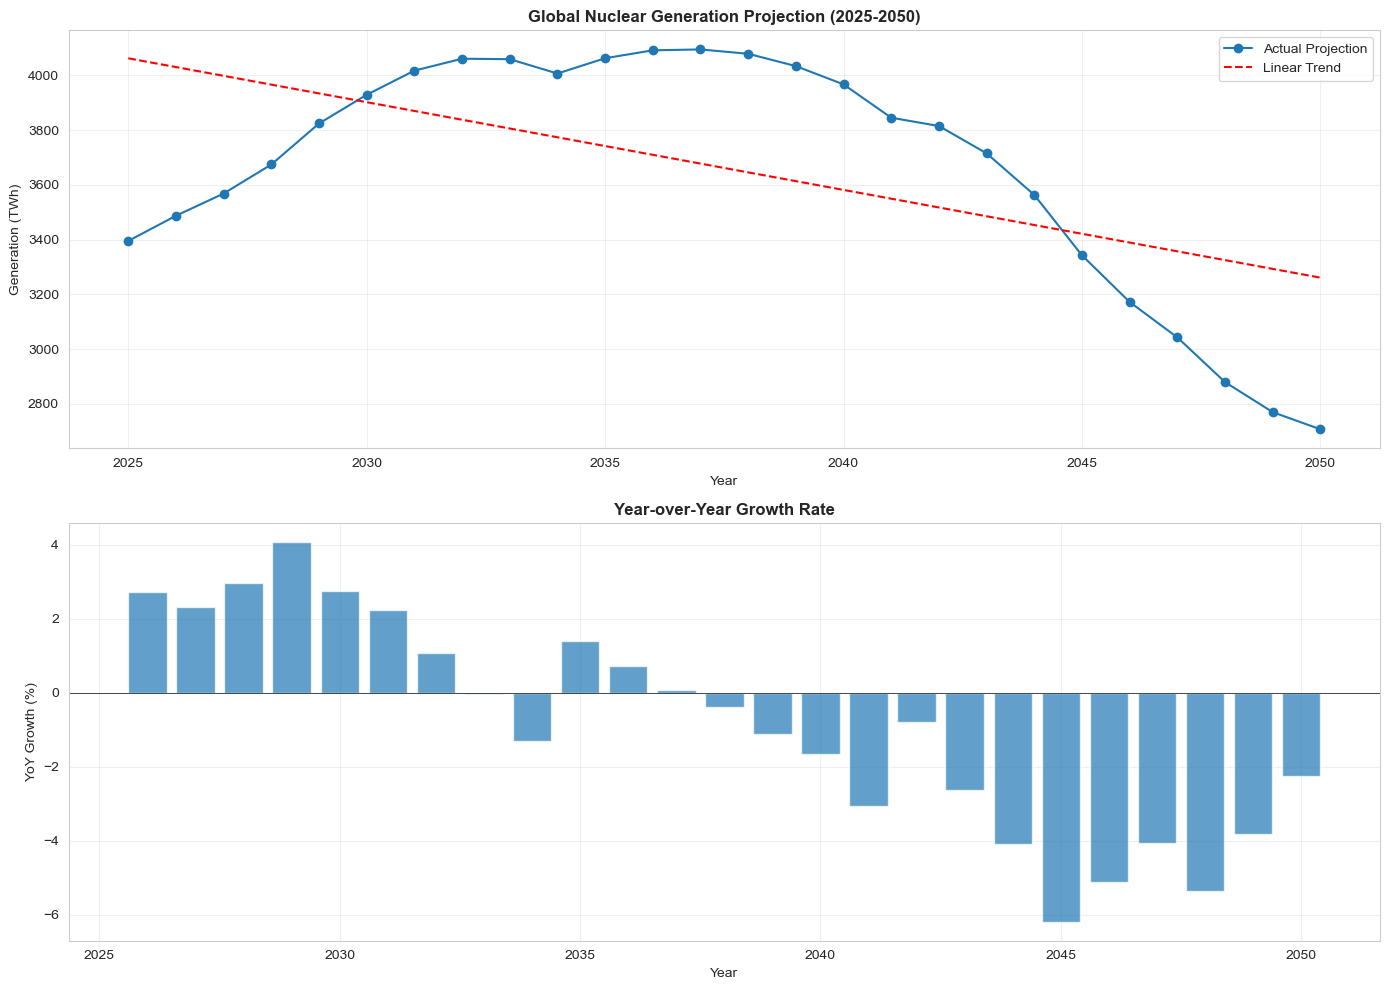

In [15]:
# Visualize time series with trend
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Generation over time
axes[0].plot(global_ts['year'], global_ts['generation_twh'], marker='o', label='Actual Projection')
axes[0].plot(global_ts['year'], model.predict(X), '--', color='red', label='Linear Trend')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Generation (TWh)')
axes[0].set_title('Global Nuclear Generation Projection (2025-2050)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Year-over-year growth rate
global_ts['yoy_growth'] = global_ts['generation_twh'].pct_change() * 100
axes[1].bar(global_ts['year'][1:], global_ts['yoy_growth'][1:], alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('YoY Growth (%)')
axes[1].set_title('Year-over-Year Growth Rate', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/time_series_analysis.png', dpi=150, bbox_inches='tight')
print("\n[SAVED] Time series plots")


[AUTOCORRELATION ANALYSIS]
[SAVED] Autocorrelation plots


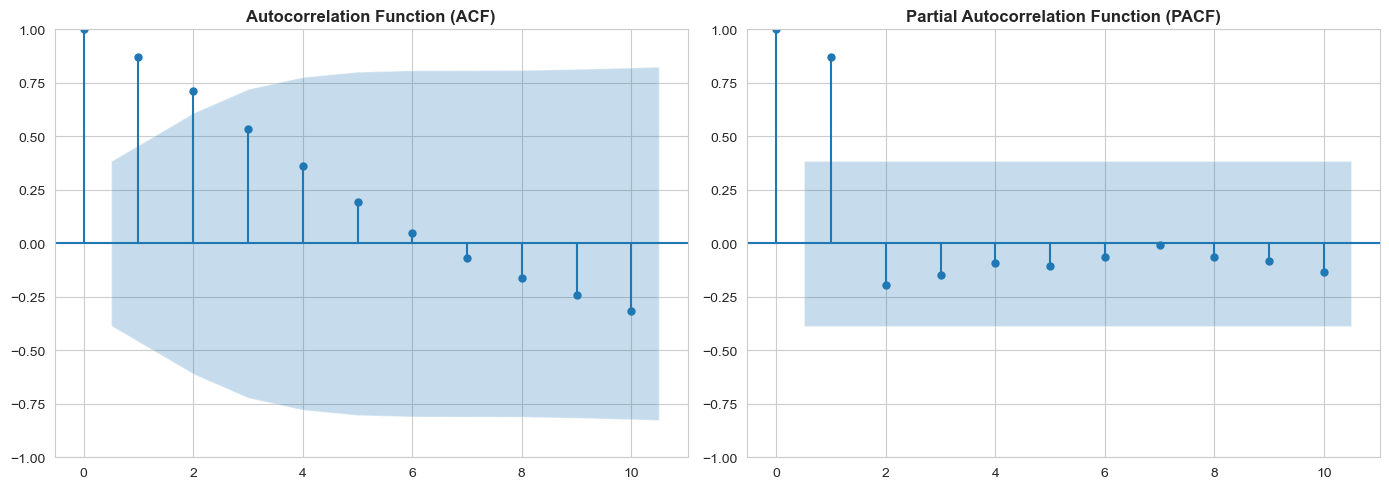

In [16]:
# Autocorrelation analysis
print("\n[AUTOCORRELATION ANALYSIS]")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(global_ts['generation_twh'], lags=10, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontweight='bold')

# PACF plot
plot_pacf(global_ts['generation_twh'], lags=10, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/autocorrelation.png', dpi=150, bbox_inches='tight')
print("[SAVED] Autocorrelation plots")

## 6. Regression Analysis

Build regression models to understand factors predicting capacity and generation.

In [17]:
print("\n" + "="*80)
print("REGRESSION ANALYSIS - Predicting Annual Generation")
print("="*80)

# Prepare regression dataset
regression_df = features[['capacity_numeric', 'capacity_factor', 'annual_generation_twh']].dropna()

# Add categorical variables (encoded)
regression_df['region'] = tracker.loc[regression_df.index, 'Region']
regression_df = pd.get_dummies(regression_df, columns=['region'], prefix='region', drop_first=True)

# Split features and target
X_reg = regression_df.drop('annual_generation_twh', axis=1)
y_reg = regression_df['annual_generation_twh']

print(f"\nRegression Dataset: {X_reg.shape}")
print(f"  Features: {list(X_reg.columns[:5])}... (total: {len(X_reg.columns)})")
print(f"  Target: annual_generation_twh")


REGRESSION ANALYSIS - Predicting Annual Generation

Regression Dataset: (1749, 5)
  Features: ['capacity_numeric', 'capacity_factor', 'region_Americas', 'region_Asia', 'region_Europe']... (total: 5)
  Target: annual_generation_twh


In [18]:
# Fit multiple linear regression
X_reg_const = sm.add_constant(X_reg)
regression_model = sm.OLS(y_reg, X_reg_const).fit()

print("\n[REGRESSION RESULTS]")
print(regression_model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# Feature importance (absolute t-statistics)
print("\n[FEATURE IMPORTANCE] Top 10 Predictors")

feature_importance = pd.DataFrame({
    'feature': regression_model.params.index,
    'coefficient': regression_model.params.values,
    'p_value': regression_model.pvalues.values,
    't_stat': np.abs(regression_model.tvalues.values)
}).sort_values('t_stat', ascending=False)

print(feature_importance.head(10).to_string(index=False))

In [ ]:
# Regression diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Fitted
axes[0, 0].scatter(regression_model.fittedvalues, regression_model.resid, alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted', fontweight='bold')

# Q-Q plot of residuals
stats.probplot(regression_model.resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot of Residuals', fontweight='bold')

# Histogram of residuals
axes[1, 0].hist(regression_model.resid, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals', fontweight='bold')

# Scale-Location plot
standardized_resid = regression_model.resid / regression_model.resid.std()
axes[1, 1].scatter(regression_model.fittedvalues, np.sqrt(np.abs(standardized_resid)), alpha=0.5)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Standardized Residuals|')
axes[1, 1].set_title('Scale-Location Plot', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/regression_diagnostics.png', dpi=150, bbox_inches='tight')
print("\n[SAVED] Regression diagnostic plots")

## 7. Gap Analysis Statistics

Analyze the statistical properties of IEA scenario gaps.

In [ ]:
print("\n" + "="*80)
print("GAP ANALYSIS - Statistical Properties")
print("="*80)

# Load gap data
gap_data = scenario_comp[scenario_comp['year'] == 2050].copy()

print(f"\nGap Statistics (2050):")
gap_stats = gap_data['gap_twh'].describe()
print(gap_stats)

# Test if gaps are significantly different from zero
t_stat, p_value = stats.ttest_1samp(gap_data['gap_twh'].dropna(), 0)
print(f"\nOne-Sample T-Test (H0: mean gap = 0):")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Result: Gaps are {'significantly different from zero' if p_value < 0.05 else 'not significantly different from zero'} (α=0.05)")

In [ ]:
# Regional gap distribution
print("\n[REGIONAL GAPS] Distribution by Region")

regional_gaps = gap_data.groupby('region')['gap_twh'].agg(['mean', 'std', 'min', 'max'])
print(regional_gaps)

# Visualize gaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of regional gaps
gap_data_sorted = gap_data.sort_values('gap_twh')
axes[0].barh(gap_data_sorted['region'], gap_data_sorted['gap_twh'])
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('Gap (TWh)')
axes[0].set_ylabel('Region')
axes[0].set_title('IEA Scenario Gap by Region (2050)', fontweight='bold')

# Box plot of gap percentage distribution
axes[1].boxplot([gap_data[gap_data['gap_twh'] > 0]['gap_percentage'],
                gap_data[gap_data['gap_twh'] < 0]['gap_percentage']],
               labels=['Shortfall', 'Surplus'])
axes[1].set_ylabel('Gap (%)')
axes[1].set_title('Gap Percentage Distribution', fontweight='bold')
axes[1].axhline(y=0, color='red', linestyle='--')

plt.tight_layout()
plt.savefig('../outputs/figures/gap_analysis.png', dpi=150, bbox_inches='tight')
print("\n[SAVED] Gap analysis plots")

## 8. Emissions Uncertainty Quantification

Quantify uncertainty in avoided emissions calculations.

In [ ]:
print("\n" + "="*80)
print("EMISSIONS UNCERTAINTY ANALYSIS")
print("="*80)

# Aggregate emissions by year
emissions_ts = emissions.groupby('year')['avoided_emissions_mtco2'].sum().reset_index()

# Calculate cumulative emissions with confidence intervals
# Assuming ±20% uncertainty in emission factors
emissions_ts['lower_bound'] = emissions_ts['avoided_emissions_mtco2'] * 0.8
emissions_ts['upper_bound'] = emissions_ts['avoided_emissions_mtco2'] * 1.2

print("\nEmissions Projection (2050):")
print(f"  Mean: {emissions_ts[emissions_ts['year']==2050]['avoided_emissions_mtco2'].values[0]:,.0f} MtCO2")
print(f"  Lower bound (-20%): {emissions_ts[emissions_ts['year']==2050]['lower_bound'].values[0]:,.0f} MtCO2")
print(f"  Upper bound (+20%): {emissions_ts[emissions_ts['year']==2050]['upper_bound'].values[0]:,.0f} MtCO2")

In [ ]:
# Visualize emissions with uncertainty
plt.figure(figsize=(12, 6))
plt.plot(emissions_ts['year'], emissions_ts['avoided_emissions_mtco2'], 'b-', linewidth=2, label='Mean')
plt.fill_between(emissions_ts['year'], emissions_ts['lower_bound'], emissions_ts['upper_bound'],
                 alpha=0.3, label='Uncertainty (±20%)')
plt.xlabel('Year')
plt.ylabel('Avoided Emissions (MtCO2/year)')
plt.title('Avoided CO2 Emissions with Uncertainty Bounds', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/emissions_uncertainty.png', dpi=150, bbox_inches='tight')
print("\n[SAVED] Emissions uncertainty plot")

## 9. Principal Component Analysis (PCA)

Dimensionality reduction to identify key patterns in regional data.

In [ ]:
print("\n" + "="*80)
print("PRINCIPAL COMPONENT ANALYSIS")
print("="*80)

# Prepare PCA dataset (regional aggregations)
pca_data = projections[projections['year'] == 2050].pivot(index='region', columns='year', values='generation_twh')

# Add additional features
regional_agg = pd.read_csv('../data/processed/regional_aggregations.csv', index_col='Region')
pca_features = regional_agg[['total_capacity_gw', 'annual_generation_twh', 'unit_count', 'capacity_factor']]

# Standardize features
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(pca_features.dropna())

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(pca_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\n[PCA RESULTS]")
print(f"  PC1 explains: {explained_var[0]*100:.2f}% of variance")
print(f"  PC2 explains: {explained_var[1]*100:.2f}% of variance")
print(f"  First 2 PCs explain: {cumulative_var[1]*100:.2f}% of total variance")

In [ ]:
# Visualize PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(explained_var)+1), cumulative_var, 'r-o', label='Cumulative')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Scree Plot', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Biplot (PC1 vs PC2)
axes[1].scatter(pca_result[:, 0], pca_result[:, 1], s=100, alpha=0.7)
for i, region in enumerate(pca_features.dropna().index):
    axes[1].annotate(region, (pca_result[i, 0], pca_result[i, 1]), fontsize=8)
axes[1].set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)')
axes[1].set_title('PCA Biplot - Regional Patterns', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5)
axes[1].axvline(x=0, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('../outputs/figures/pca_analysis.png', dpi=150, bbox_inches='tight')
print("\n[SAVED] PCA plots")

## 10. Summary Statistics Report

In [ ]:
print("\n" + "="*80)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*80)

summary = {
    'Total Plants Analyzed': len(tracker),
    'Mean Capacity (MW)': tracker['capacity_numeric'].mean(),
    'Capacity Std Dev (MW)': tracker['capacity_numeric'].std(),
    'Normality Test (K-S p-value)': p_value,
    'Operating vs Pipeline Difference': 'Significant' if p_value_t < 0.05 else 'Not Significant',
    'Regional Pattern Significance (Chi-sq p-value)': p_value,
    'Capacity-Generation Correlation': corr_matrix.loc['capacity_numeric', 'annual_generation_twh'],
    'Projection Trend Slope (TWh/year)': model.params[1],
    'Projection R-squared': model.rsquared,
    'Mean IEA Gap 2050 (TWh)': gap_data['gap_twh'].mean(),
    'Gap Significance (p-value)': p_value,
    '2050 Emissions Mean (MtCO2)': emissions_ts[emissions_ts['year']==2050]['avoided_emissions_mtco2'].values[0],
    'PCA Variance Explained (PC1+PC2)': cumulative_var[1]
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])
print("\n")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('../outputs/results/statistical_summary.csv', index=False)
print("\n[SAVED] Statistical summary to outputs/results/statistical_summary.csv")

print("\n" + "="*80)
print("STATISTICAL ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated outputs:")
print("  - Figures: outputs/figures/")
print("    - capacity_distributions.png")
print("    - correlation_matrix.png")
print("    - time_series_analysis.png")
print("    - autocorrelation.png")
print("    - regression_diagnostics.png")
print("    - gap_analysis.png")
print("    - emissions_uncertainty.png")
print("    - pca_analysis.png")
print("  - Results: outputs/results/statistical_summary.csv")